# Auxiliary EDA on the visited sites

In [1]:
import pandas as pd
import numpy as np

In [2]:
visits = pd.read_csv("results/training.site_visits.csv.gz")
joe_visits = visits.query("is_joe")

In [4]:
n_visits = len(visits)
n_joe_visits = len(joe_visits)

n_sites = len(visits["site"].unique())
n_joe_sites = len(joe_visits["site"].unique())

print(f"There are {n_visits:,} total visits recorded.")
print(f"{n_joe_visits:,} of those visits are from Joe.")
print('--')
print(f"There are {n_sites:,} unique visited sites in the dataset.")
print(f"Joe visited {n_joe_sites:,} ({n_joe_sites/n_sites:.2%}) of those sites at least once.")

There are 2,065,873 total visits recorded.
10,503 of those visits are from Joe.
--
There are 157,771 unique visited sites in the dataset.
Joe visited 1,515 (0.96%) of those sites at least once.


## Joe's frequent sites

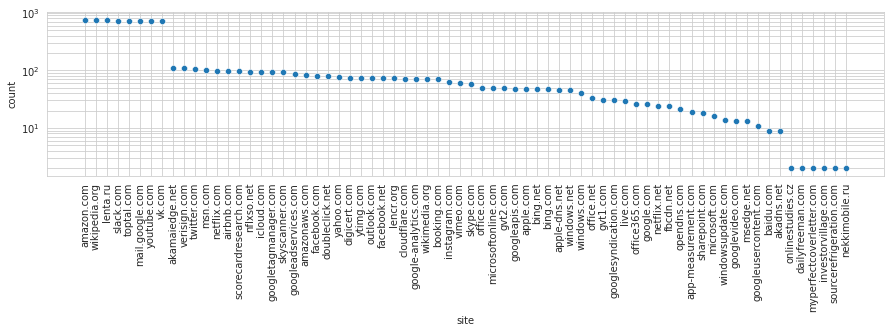

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

joe_visits_count = joe_visits["site"].value_counts()
joe_visits_count = joe_visits_count.reset_index()
joe_visits_count.columns = ["site", "count"]

sns.set_style("whitegrid")

fig, ax = plt.subplots(1, 1, figsize=(15, 3))

sns.scatterplot(
    data=joe_visits_count.query("count > 1"),
    x="site",
    y="count",
    ax=ax
)

plt.grid(visible=True, which="minor", axis="y")

_ = plt.xticks(rotation=90)
ax.set_yscale("log")

In [6]:
joe_visits_count.query("count > 700")

,site,count
0,amazon.com,755
1,wikipedia.org,752
2,lenta.ru,742
3,slack.com,736
4,toptal.com,727
5,mail.google.com,726
6,youtube.com,721
7,vk.com,718


There are a few sites that Joe visits very frequently: lenta.ru, slack.com, toptal.com, mail.google.com, youtube.com, vk.com.

In [7]:
joe_visits_count.query("count > 1")

,site,count
0,amazon.com,755
1,wikipedia.org,752
2,lenta.ru,742
3,slack.com,736
4,toptal.com,727
...,...,...
65,dailyfreeman.com,2
66,myperfectcoverletter.com,2
67,investorvillage.com,2
68,sourcerefrigeration.com,2


In [8]:
len(joe_visits_count.query("count == 1"))

1445

- There are a few sites (8) that Joe visits very frequently.
- There's a small group of sites (70) that Joe visits less frequently, but that he has visited more than once.
- There's a long tail of sites (1,445) that Joe visited only once in the training dataset.

## Select the most informative sites

We will select the sites that are frequent for the general population plus the sites that Joe visited more than once.

In [9]:
visits_count_everyone = visits["site"].value_counts()
visits_count_joe = joe_visits["site"].value_counts()

visits_pct_everyone = 100 * visits["site"].value_counts(normalize=True)
visits_pct_joe = 100 * joe_visits["site"].value_counts(normalize=True)

visits_wide = pd.concat([
    visits_pct_everyone,
    visits_count_everyone,
    visits_pct_joe,
    visits_count_joe,
], axis=1)
visits_wide.fillna(0, inplace=True)
visits_wide.columns = ["everyone_pct", "everyone_count", "joe_pct", "joe_count"]
visits_wide.sort_values(by=["joe_count"], ascending=False, inplace=True)
visits_wide["diff_pct"] = visits_wide["joe_pct"] - visits_wide["everyone_pct"]
visits_wide["diff_pct_abs"] = np.abs(visits_wide["diff_pct"])

In [10]:
joe_visited_more_than_once = visits_wide["joe_count"] > 1
frequent_for_the_avg_user = visits_wide["everyone_pct"] > 0.1

top_sites = visits_wide[
    joe_visited_more_than_once | frequent_for_the_avg_user 
].copy()
top_sites.head(10).round(2)

,everyone_pct,everyone_count,joe_pct,joe_count,diff_pct,diff_pct_abs
amazon.com,7.46,154135,7.19,755.0,-0.27,0.27
wikipedia.org,7.31,151104,7.16,752.0,-0.15,0.15
lenta.ru,2.13,44028,7.06,742.0,4.93,4.93
slack.com,2.15,44387,7.01,736.0,4.86,4.86
toptal.com,1.81,37416,6.92,727.0,5.11,5.11
mail.google.com,2.18,44960,6.91,726.0,4.74,4.74
youtube.com,2.18,45036,6.86,721.0,4.68,4.68
vk.com,2.74,56539,6.84,718.0,4.10,4.10
akamaiedge.net,1.39,28685,1.05,110.0,-0.34,0.34
verisign.com,1.42,29426,1.04,109.0,-0.39,0.39


In [9]:
joe_visited = visits_wide["joe_count"] > 1
frequent_for_the_avg_user = visits_wide["everyone_pct"] > 0.1

with open("results/extra-sites.list") as f:
    extra_sites = {l.strip() for l in f}
    
is_site_associated_to_bad_prediction = visits_wide.index.isin(extra_sites)

selected_sites = visits_wide[
    joe_visited | frequent_for_the_avg_user | is_site_associated_to_bad_prediction
]
selected_sites

,everyone_pct,everyone_count,joe_pct,joe_count,diff_pct,diff_pct_abs
amazon.com,7.461010,154135,7.188422,755.0,-0.272588,0.272588
wikipedia.org,7.314293,151104,7.159859,752.0,-0.154434,0.154434
lenta.ru,2.131206,44028,7.064648,742.0,4.933443,4.933443
slack.com,2.148583,44387,7.007522,736.0,4.858938,4.858938
toptal.com,1.811147,37416,6.921832,727.0,5.110685,5.110685
...,...,...,...,...,...,...
decapitating.space,0.000097,2,0.000000,0.0,-0.000097,0.000097
fastopo.com,0.000097,2,0.000000,0.0,-0.000097,0.000097
catapultx.com,0.000097,2,0.000000,0.0,-0.000097,0.000097
esprit.fr,0.000097,2,0.000000,0.0,-0.000097,0.000097


In [10]:
top_sites.query("diff_pct_abs > 1").round(1).head(20)

,everyone_pct,everyone_count,joe_pct,joe_count,diff_pct,diff_pct_abs
lenta.ru,2.1,44028,7.1,742.0,4.9,4.9
slack.com,2.1,44387,7.0,736.0,4.9,4.9
toptal.com,1.8,37416,6.9,727.0,5.1,5.1
mail.google.com,2.2,44960,6.9,726.0,4.7,4.7
youtube.com,2.2,45036,6.9,721.0,4.7,4.7
vk.com,2.7,56539,6.8,718.0,4.1,4.1


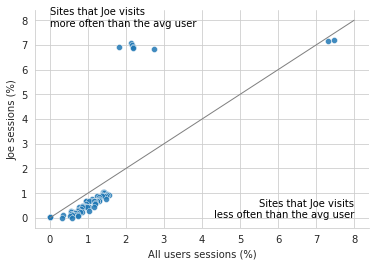

In [11]:
ax = sns.scatterplot(
    data=top_sites,
    x="everyone_pct",
    y="joe_pct",
    alpha=0.85,
    legend=False,
)

annot = "Sites that Joe visits\nmore often than the avg user"
ax.text(x=0, y=7.75, s=annot, color="k", ha="left")

annot = "Sites that Joe visits\nless often than the avg user"
ax.text(x=8, y=0, s=annot, color="k", ha="right")

sns.despine(ax=ax)

ax.set_ylabel("Joe sessions (%)")
ax.set_xlabel("All users sessions (%)")

_ = ax.plot([0, 8], [0, 8], lw=1, color="grey")

Interestingly, Joe visits with less frequency than the average users most of the dataset's most visited sites.

In [12]:
fp = "results/training.selected_sites.sm.csv.gz"
top_sites.index.name = "site"
top_sites.to_csv(fp)

fp = "results/training.selected_sites.sm.list"
top_sites.reset_index()[["site"]].to_csv(fp, index=False, header=False)

top_sites

,everyone_pct,everyone_count,joe_pct,joe_count,diff_pct,diff_pct_abs
site,,,,,,
amazon.com,7.461010,154135,7.188422,755.0,-0.272588,0.272588
wikipedia.org,7.314293,151104,7.159859,752.0,-0.154434,0.154434
lenta.ru,2.131206,44028,7.064648,742.0,4.933443,4.933443
slack.com,2.148583,44387,7.007522,736.0,4.858938,4.858938
toptal.com,1.811147,37416,6.921832,727.0,5.110685,5.110685
...,...,...,...,...,...,...
myperfectcoverletter.com,0.000145,3,0.019042,2.0,0.018897,0.018897
investorvillage.com,0.000097,2,0.019042,2.0,0.018945,0.018945
nekkimobile.ru,0.000194,4,0.019042,2.0,0.018849,0.018849


In [13]:
fp = "results/training.selected_sites.big.csv.gz"
selected_sites.index.name = "site"
selected_sites.to_csv(fp)

fp = "results/training.selected_sites.big.list"
selected_sites.reset_index()[["site"]].to_csv(fp, index=False, header=False)

selected_sites

,everyone_pct,everyone_count,joe_pct,joe_count,diff_pct,diff_pct_abs
site,,,,,,
amazon.com,7.461010,154135,7.188422,755.0,-0.272588,0.272588
wikipedia.org,7.314293,151104,7.159859,752.0,-0.154434,0.154434
lenta.ru,2.131206,44028,7.064648,742.0,4.933443,4.933443
slack.com,2.148583,44387,7.007522,736.0,4.858938,4.858938
toptal.com,1.811147,37416,6.921832,727.0,5.110685,5.110685
...,...,...,...,...,...,...
decapitating.space,0.000097,2,0.000000,0.0,-0.000097,0.000097
fastopo.com,0.000097,2,0.000000,0.0,-0.000097,0.000097
catapultx.com,0.000097,2,0.000000,0.0,-0.000097,0.000097


## URL domains

In [14]:
from operator import itemgetter

visits["tld"] = visits["site"].str.split(".").map(lambda l: l[1] if len(l) > 1 else ".")

In [15]:
domains = pd.concat([
    100 * visits["tld"].value_counts(normalize=True).rename("all_pct").to_frame(),
    100 * visits.query("is_joe")["tld"].value_counts(normalize=True).rename("joe_pct").to_frame(),
], axis=1)

domains.head(20)

,all_pct,joe_pct
com,68.952399,66.485766
net,12.333188,6.712368
org,10.394831,9.102161
ru,2.338769,7.302675
google,2.177530,6.912311
io,0.253694,0.295154
de,0.245030,0.228506
xyz,0.149864,0.161859
co,0.130647,0.095211
nl,0.104895,0.085690


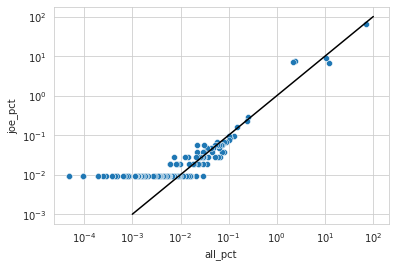

In [16]:
ax = sns.scatterplot(data=domains, x="all_pct", y="joe_pct")
ax.plot([1e-3, 100], [1e-3, 100], color="k")
ax.set_yscale("log")
ax.set_xscale("log")